# 1. Import dependencies and data sets

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf

In [2]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
array-record                 0.4.1
arrow                        1.3.0
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.3.0
click                        8.1.7
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.12.0
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
dm-tree                      0.1.8
eti

In [3]:
hasGPUSupport = tf.test.is_built_with_cuda()
gpuList = tf.config.list_physical_devices('GPU')
print("Tensorflow Compiled with CUDA/GPU Support:", hasGPUSupport)
print("Tensorflow can access", len(gpuList), "GPU")
print("Accessible GPUs are:")
print(gpuList)

Tensorflow Compiled with CUDA/GPU Support: True
Tensorflow can access 0 GPU
Accessible GPUs are:
[]


In [4]:
for gpu in gpuList:
    tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
#bringing in fashion mnist dataset
ds = tfds.load('fashion_mnist',split='train')

In [7]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# 2. Visualizing Data Set

In [4]:
import numpy as np

In [5]:
#Setting up data iterator
data_iterator = ds.as_numpy_iterator()

In [10]:
#Getting data out of the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

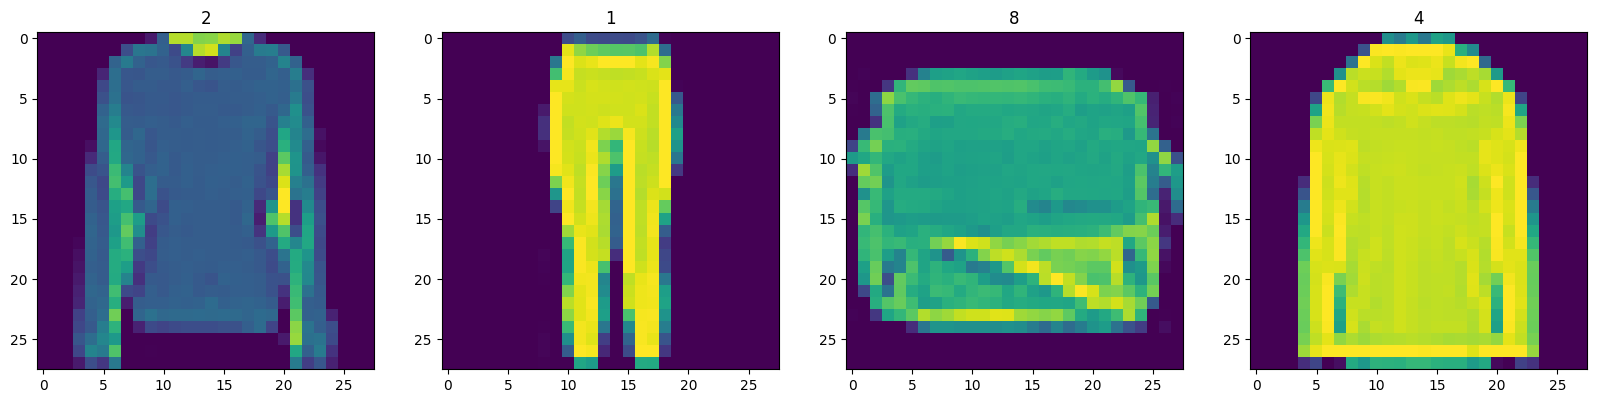

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [7]:
#Scale and return images only
def scale_images(data):
    image = data['image']
    return image/255

# 3. Preping the Dataset for Training

In [8]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [9]:
#Reload the dataset
ds = tfds.load('fashion_mnist',split='train')
#Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
#cache the dataset from that batch
ds = ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#Reduces the likelihood of bottle necking
ds = ds.prefetch(64)

# 4. Building the Neural Network

## 4.1. Building the Generator

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [12]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshape it to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Up-sampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Up-sampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to get to one Channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))

    return model

In [26]:
generator = build_generator()
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 146ms/step


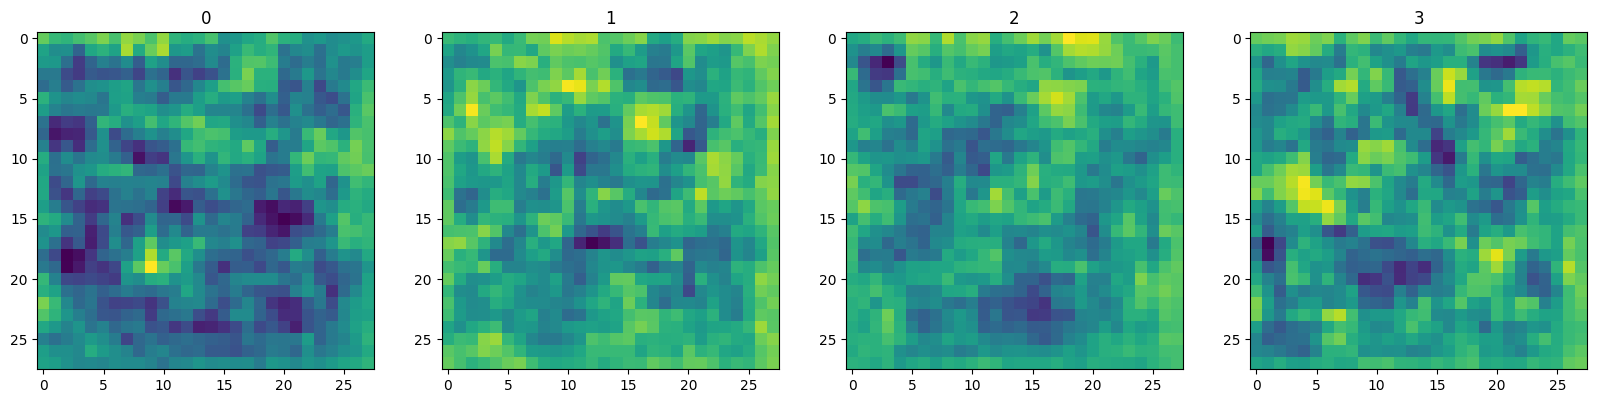

In [14]:
#testing the generator model by generating new random sampling
input_x = np.random.randn(4,128,1)
img = test_model.predict(input_x)
#visualizing the images generated
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img_ in enumerate(img):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(img_))
    ax[idx].title.set_text(idx)

## 4.2. Building the Discriminator

In [15]:
def build_discriminator():
    model = Sequential()
    
    #First Conv Block
    model.add(Conv2D(32,5,input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Second Conv Block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Third Conv Block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Fourth Conv Block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4)) #questionable layer
    model.add(Dense(1,activation='sigmoid'))
    
    return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [18]:
img.shape

(4, 28, 28, 1)

In [19]:
discriminator.predict(img)

1/1 [==============================] - 0s 61ms/step


array([[0.5051652 ],
       [0.50537246],
       [0.5054217 ],
       [0.50538653]], dtype=float32)

# 5. Constructing Training Loop

## 5.1. Setup Losses and Optimizers

In [20]:
#optimizer and loss function for both generator and discriminator
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001) #It is better if the discriminator learning rate is lower than of the generator

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 5.2. Setting up Subclassed Models

In [22]:
#Importing the base model class to subclass 
from keras.models import Model

In [ ]:
###### Do not Run This Sell
###### other way to write subclass functions (example)

@tf.function
def train_step():
    pass

In [36]:
class FashionGAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        #pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        #creating attributes
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with base class
        super().compile(*args,**kwargs)
        
        #creating attributes
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self,batch):
        #get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        
        #train the discriminator
        with tf.GradientTape() as d_tape:
            #1. Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images,training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake], axis=0)
            
            #2. Create labels for real and fake images
            y_realfake =tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)], axis=0)
            
            #3. Add some noise to the output
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake],axis=0)
            
            #4. Calculate loss
            total_d_loss = self.d_loss(y_realfake,yhat_realfake)
            
        #5. Apply back-propagation - nn learn
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape:
            #1. Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)),training=True)
            
            #2. Create  the predicted labels
            predicted_labels = self.discriminator(gen_images,training=False)
            
            #3. Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        #4. Apply backprop
        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
            

In [37]:
#creating an instance of the subclass model
fashgen = FashionGAN(generator,discriminator)

In [38]:
#compile the model
fashgen.compile( g_opt, d_opt, g_loss, d_loss)

## 5.3 Build Callback

In [39]:
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [40]:
os.path

<module 'posixpath' from '/home/genai/miniconda3/envs/genAi2/lib/python3.10/posixpath.py'>

In [41]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images*=255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images',f'generated_img_{epoch}_{i}.png'))

## 5.4 Train

In [43]:
hist = fashgen.fit(ds,epochs=2000, callbacks=[ModelMonitor()])

Epoch 1/2000
469/469 [==============================] - 839s 2s/step - d_loss: 0.5928 - g_loss: 0.8153
Epoch 2/2000
469/469 [==============================] - 837s 2s/step - d_loss: 0.6572 - g_loss: 0.5227
Epoch 3/2000
 43/469 [=>............................] - ETA: 12:50 - d_loss: 0.7632 - g_loss: 0.4322

KeyboardInterrupt: 

In [ ]:
modelPath = '/content/drive/My Drive/Generative AI/SavedModels/'
fashgen.generator.save(f'{modelPath}/FashionGANGenerator.h5')
fashgen.discriminator.save(f'{modelPath}/FashionGANDiscriminator.h5')

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 6. Testing out Generator

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])